In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
folder_path = r'data/'
csv_path = folder_path + 'Fulldata_age.csv'
df = pd.read_csv(csv_path)

In [6]:
full_df = df.sample(frac=0.1, random_state=42)

train_df = full_df.copy()
train_df = train_df[train_df['Value_SoH'] > 0.79]
#train_df = train_df[train_df['Folder'] == 1]
#Dropable Columns
training_columns = ['Time','Value_U','Value_I','Value_SoC','Value_SoH','Cumulative_Ah','Value_Age','Value_NumCharge','Value_NcT80']
#training_columns = ['Value_SoH','Value_NumCharge','Value_Age','Value_NcT80']
#training_columns = ['Time','Value_U','Value_I','Value_SoC','Value_SoH','Value_NcT80']
train_df = train_df[training_columns]
train_df.info()
train_df.head()

#Prediciton Columns
pred_columns = ['Value_SoH','Value_NcT80']
#pred_columns = ['Value_NcT80']

<class 'pandas.core.frame.DataFrame'>
Index: 161015 entries, 119162 to 1119089
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             161015 non-null  int64  
 1   Value_U          161015 non-null  float64
 2   Value_I          161015 non-null  float64
 3   Value_SoC        161015 non-null  float64
 4   Value_SoH        161015 non-null  float64
 5   Cumulative_Ah    161015 non-null  float64
 6   Value_Age        161015 non-null  int64  
 7   Value_NumCharge  161015 non-null  int64  
 8   Value_NcT80      161015 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 12.3 MB


Value_SoH
Time              -0.001372
Value_U           -0.020421
Value_I            0.021878
Value_SoC         -0.002235
Value_SoH          1.000000
Cumulative_Ah     -0.907096
Value_Age         -0.728028
Value_NumCharge   -0.822768
Value_NcT80        0.863706
Name: Value_SoH, dtype: float64
Value_NcT80
Time              -0.098556
Value_U           -0.123344
Value_I            0.020883
Value_SoC         -0.073026
Value_SoH          0.863706
Cumulative_Ah     -0.685344
Value_Age         -0.743395
Value_NumCharge   -0.563778
Value_NcT80        1.000000
Name: Value_NcT80, dtype: float64


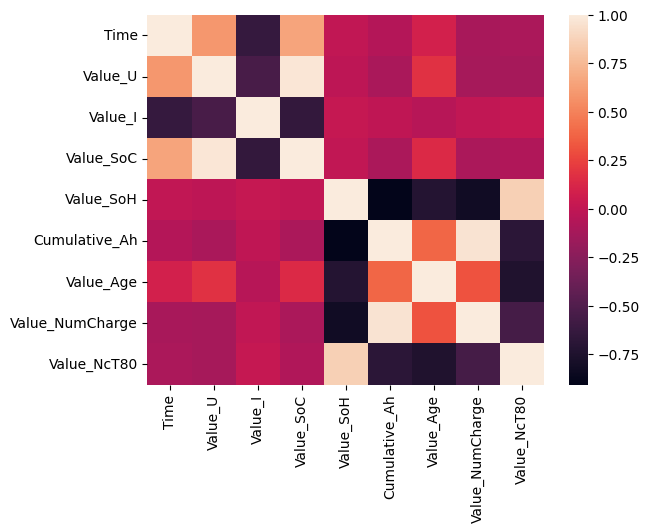

In [7]:
corr = train_df.corr()
fig, ax = plt.subplots()
sns.heatmap(corr)
for col in pred_columns:
  print(col)
  print(corr[col])


In [8]:
from sklearn.model_selection import train_test_split

X = dict()
y = dict()
X_train = dict()
meta =dict()
X_test = dict()
y_train = dict()
y_test = dict()
y_pred = dict()

In [9]:
X = train_df.drop(pred_columns,axis=1)
y_columns = pred_columns
y = train_df[y_columns]
print(y.shape,X.shape)



#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['Value_Age'])
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,   test_size=0.5, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.info()
y_train.info()

(161015, 2) (161015, 7)
(112710, 7) (24152, 7) (112710, 2) (24152, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 112710 entries, 1372113 to 1391191
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             112710 non-null  int64  
 1   Value_U          112710 non-null  float64
 2   Value_I          112710 non-null  float64
 3   Value_SoC        112710 non-null  float64
 4   Cumulative_Ah    112710 non-null  float64
 5   Value_Age        112710 non-null  int64  
 6   Value_NumCharge  112710 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 6.9 MB
<class 'pandas.core.frame.DataFrame'>
Index: 112710 entries, 1372113 to 1391191
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Value_SoH    112710 non-null  float64
 1   Value_NcT80  112710 non-null  float64
dtypes: float64(2)
memory usage: 2.6 MB


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
y_val_scaled = scaler_y.transform(y_val)

In [12]:
import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import plot_model

In [13]:

# Funktion zum Erstellen und Trainieren des Modells
def train_model(hidden_layers, neurons):
    seed_value = 42
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

    model = keras.Sequential()
    model.add(layers.Input(X_train.shape[1]))  # Eingabeschicht

    for _ in range(hidden_layers):
        model.add(layers.Dense(neurons, activation='relu'))  # Versteckte Schicht(en)

    model.add(layers.Dense(y_train.shape[1], activation='linear'))  # Ausgabeschicht
    learning_rate = 1
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='loss', patience=8, restore_best_weights=True)
    history = model.fit(x=X_train, y=y_train_scaled, batch_size=1024, epochs=1000, callbacks=[early_stopping],validation_data=(X_val, y_val_scaled))
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.show()
    return model ,history

Number of Hidden Layers:  2  Number of Neurons:  32
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1378 (5.38 KB)
Trainable params: 1378 (5.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
111/111 [==============================] - 3s 6ms/step - loss: 0.0839 - val_loss: 0.0200
Epoch 2/1000
111/111 [==============================] - 0s 3ms/step - loss: 0.0106 - val_loss: 0.0051
Epoch 3/1000
111/111 [==========

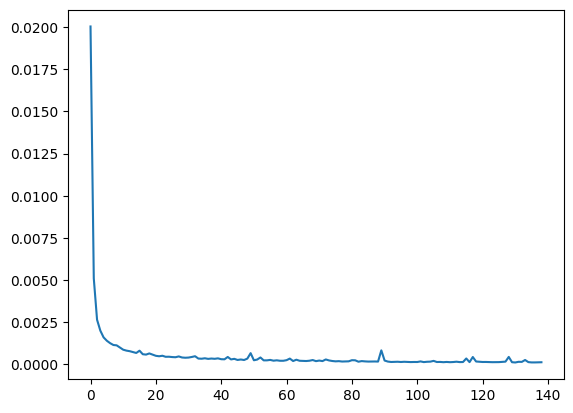

755/755 [==============================] - 1s 1ms/step
0.00012586305591863383
0.006052850725442891
  Hidden_Layer Neurons Params       MAE       MSE
0            2      32   1378  0.006053  0.000126
Das kleinste Model ist:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1378 (5.38 KB)
Trainable params: 1378 (5.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


C:\Users\teema\AppData\Local\Temp\ipykernel_12696\3449216719.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ergebnis_df = pd.concat([ergebnis_df, row], ignore_index=True)


In [14]:
hidden_layer = [1,2,3,4,6]
neurons = [1,2,4,8,16,32,64]
#hidden_layer = [2]
#neurons = [32]


ergebnis_df = pd.DataFrame(columns=['Hidden_Layer','Neurons','Params','MAE','MSE'])
s_mse_y = 1000
for num_layer in hidden_layer:
    for num_neurons in neurons:
        print("Number of Hidden Layers: ",num_layer," Number of Neurons: ", num_neurons)

        temp_model,history = train_model(num_layer,num_neurons)
        y_pred_scaled = temp_model.predict(X_test)
        num_params = temp_model.count_params()
        mse_y = mean_squared_error(y_test_scaled, y_pred_scaled)
        if (mse_y < s_mse_y):
          s_mse_y = mse_y
          s_model = temp_model
          s_pred = y_pred_scaled
        print(mse_y)
        mae_y = mean_absolute_error(y_test_scaled, y_pred_scaled)
        print(mae_y)
        row = pd.DataFrame([[num_layer, num_neurons, num_params, mae_y, mse_y]], columns=ergebnis_df.columns)
        ergebnis_df = pd.concat([ergebnis_df, row], ignore_index=True)

print(ergebnis_df)
print("Das kleinste Model ist:")
s_model.summary()
y_pred_scaled = s_pred

In [14]:
ergebnis_df['Neurons_Total'] = ergebnis_df['Neurons'] *  ergebnis_df['Hidden_Layer']
edf = ergebnis_df.sort_values(by='Neurons_Total')

# Zeilen mit den kleinsten RMSE-Werten für jeden Wert in 'Neurons_Total' auswählen
min_rmse = edf.loc[edf.groupby('Neurons_Total')['MSE'].idxmin()]

# Neues DataFrame erstellen
pareto_front_temp = min_rmse.reset_index(drop=True)

pareto_front = pd.DataFrame(columns=edf.columns)

mse_temp = 1000
for index, row in pareto_front_temp.iterrows():
    if (row['MSE'] < mse_temp):
      pareto_front = pareto_front.append(row, ignore_index=True)
      mse_temp = row['MSE']
print(ergebnis_df)

print(pareto_front)

   Hidden_Layer Neurons Params       MAE       MSE Neurons_Total
0             1       1      7  0.219029  0.066249             1
1             1       2     13  0.208415  0.061011             2
2             1       4     25  0.205959  0.060586             4
3             1       8     49  0.180985  0.049267             8
4             1      16     97  0.182409  0.050546            16
5             1      32    193  0.166649  0.044428            32
6             1      64    385  0.158351  0.041069            64
7             2       1      9  0.213936  0.064072             2
8             2       2     19  0.218863  0.066174             4
9             2       4     45  0.210287  0.062336             8
10            2       8    121  0.176937  0.047976            16
11            2      16    369  0.167347  0.044409            32
12            2      32   1249  0.145288  0.036979            64
13            2      64   4545  0.145842  0.037003           128
14            3       1  

<ipython-input-14-d34e3f974799>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pareto_front = pareto_front.append(row, ignore_index=True)


In [ ]:
#ergebnis_df.to_csv(folder_path + 'ergebnisse_grid_1.csv', index=False)

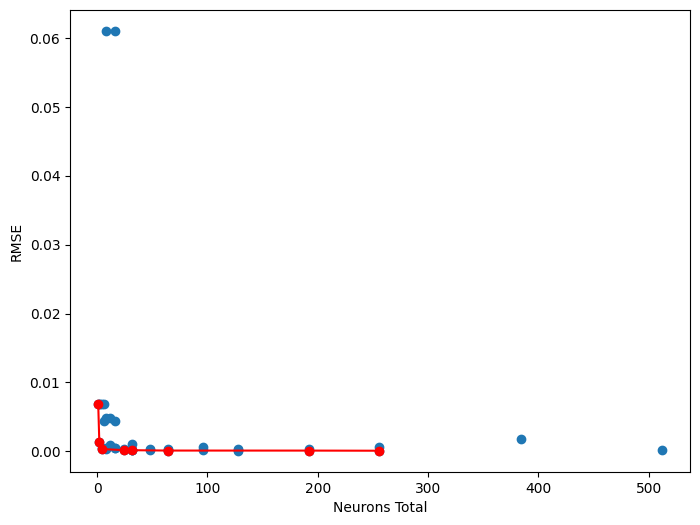

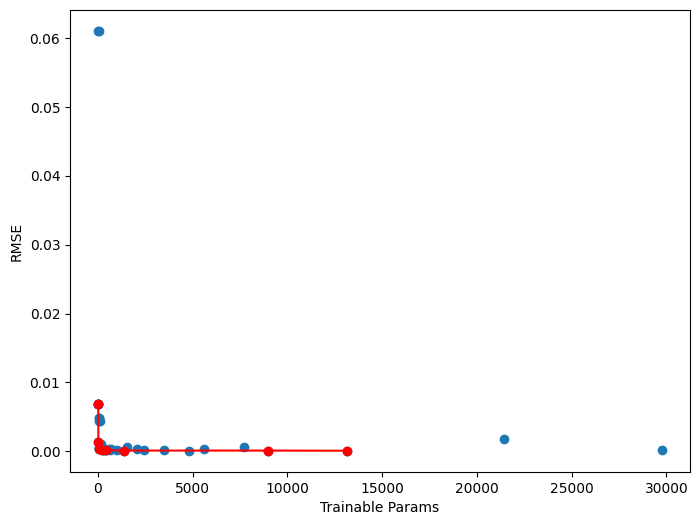

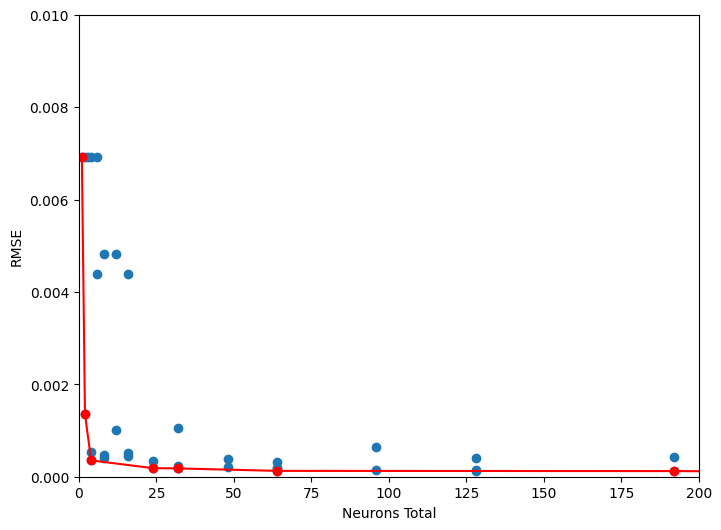

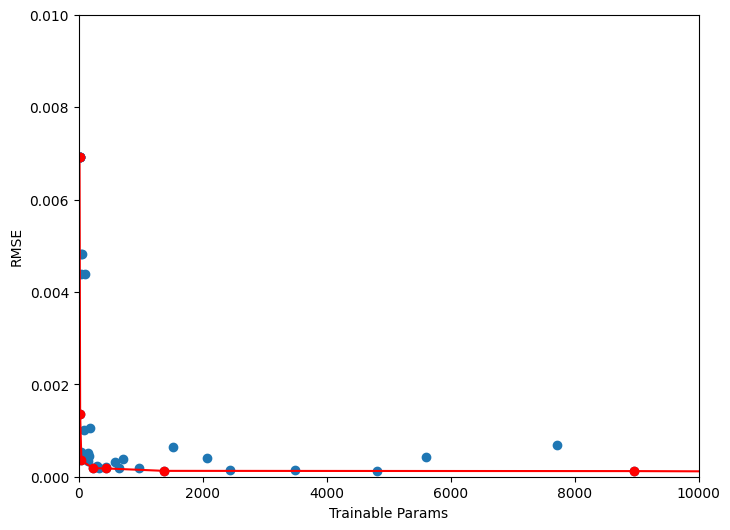

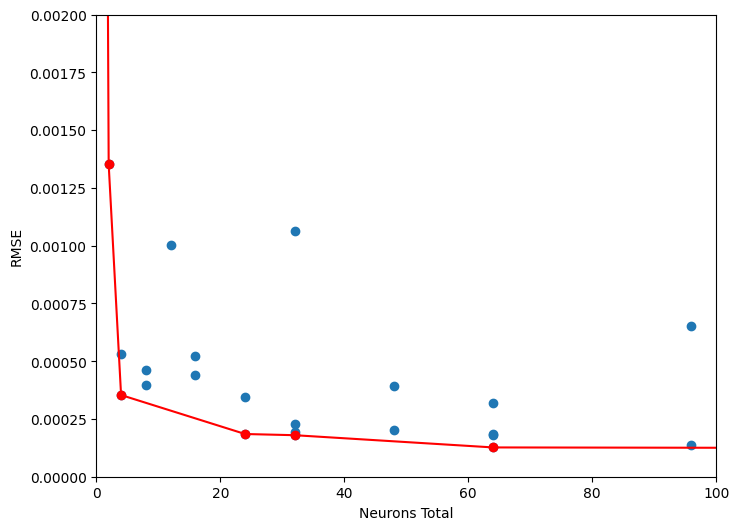

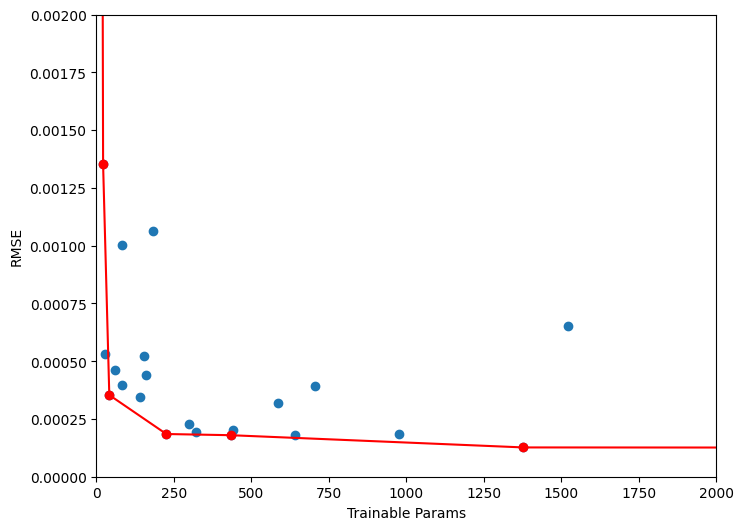

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(ergebnis_df['Neurons_Total'],ergebnis_df['MSE'])
plt.scatter(pareto_front['Neurons_Total'],pareto_front['MSE'], color='red')
plt.plot(pareto_front['Neurons_Total'],pareto_front['MSE'], color='red')
plt.xlabel('Neurons Total')
plt.ylabel('RMSE')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(ergebnis_df['Params'],ergebnis_df['MSE'])
plt.scatter(pareto_front['Params'],pareto_front['MSE'], color='red')
plt.plot(pareto_front['Params'],pareto_front['MSE'], color='red')
plt.xlabel('Trainable Params')
plt.ylabel('RMSE')
plt.show()


plt.figure(figsize=(8, 6))
plt.ylim(0,0.01)
plt.xlim(0,200)
plt.scatter(ergebnis_df['Neurons_Total'],ergebnis_df['MSE'])
plt.scatter(pareto_front['Neurons_Total'],pareto_front['MSE'], color='red')
plt.plot(pareto_front['Neurons_Total'],pareto_front['MSE'], color='red')
plt.xlabel('Neurons Total')
plt.ylabel('RMSE')
plt.show()
plt.figure(figsize=(8, 6))
plt.ylim(0,0.01)
plt.xlim(0,10000)
plt.scatter(ergebnis_df['Params'],ergebnis_df['MSE'])
plt.scatter(pareto_front['Params'],pareto_front['MSE'], color='red')
plt.plot(pareto_front['Params'],pareto_front['MSE'], color='red')
plt.xlabel('Trainable Params')
plt.ylabel('RMSE')
plt.show()

plt.figure(figsize=(8, 6))
plt.ylim(0,0.002)
plt.xlim(0,100)
plt.scatter(ergebnis_df['Neurons_Total'],ergebnis_df['MSE'])
plt.scatter(pareto_front['Neurons_Total'],pareto_front['MSE'], color='red')
plt.plot(pareto_front['Neurons_Total'],pareto_front['MSE'], color='red')
plt.xlabel('Neurons Total')
plt.ylabel('RMSE')
plt.show()
plt.figure(figsize=(8, 6))
plt.ylim(0,0.002)
plt.xlim(0,2000)
plt.scatter(ergebnis_df['Params'],ergebnis_df['MSE'])
plt.scatter(pareto_front['Params'],pareto_front['MSE'], color='red')
plt.plot(pareto_front['Params'],pareto_front['MSE'], color='red')
plt.xlabel('Trainable Params')
plt.ylabel('RMSE')
plt.show()


In [15]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test.info()
y_pred_df = pd.DataFrame(y_pred, columns=y_columns)
y_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24152 entries, 866015 to 767462
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Value_SoH    24152 non-null  float64
 1   Value_NcT80  24152 non-null  float64
dtypes: float64(2)
memory usage: 566.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24152 entries, 0 to 24151
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Value_SoH    24152 non-null  float32
 1   Value_NcT80  24152 non-null  float32
dtypes: float32(2)
memory usage: 188.8 KB


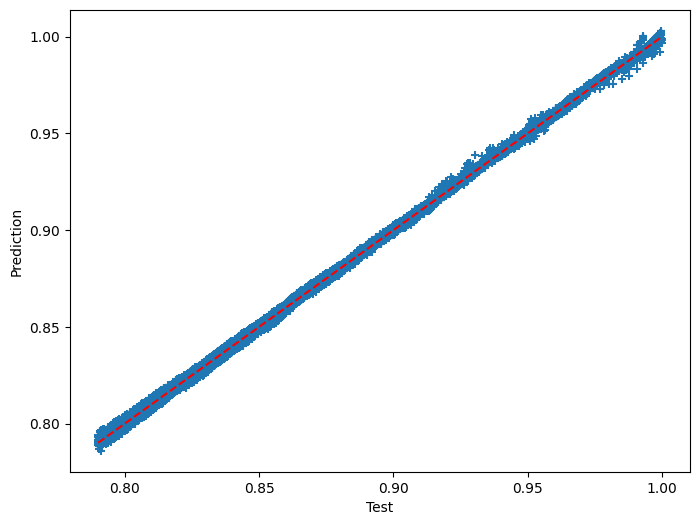

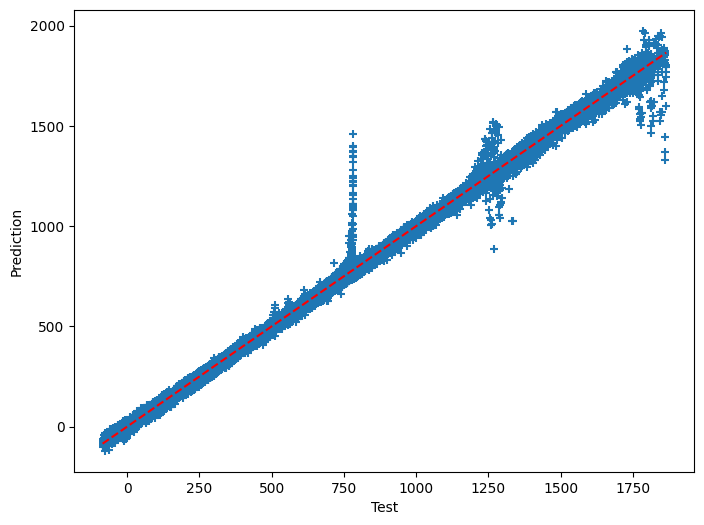

In [16]:
for pred_col in y_columns:
  plt.figure(figsize=(8, 6))
  plt.scatter(y_test[pred_col], y_pred_df[pred_col], marker='+')
  plt.plot([y_test[pred_col].min(), y_test[pred_col].max()], [y_test[pred_col].min(), y_test[pred_col].max()], color='red', linestyle='--')
  plt.xlabel('Test')
  plt.ylabel('Prediction')
  plt.show()
